### This is an exploratory attempt to:
1. Download the data from the satellites STEREO A and B, OMNI, GOES, and the DST. 
2. Correlate datasets and analyse the time shifts between STEREO and OMNI and OMNI and GOES
3. Plot the various solar wind and electron flux parameters
4. Create a basic forecasting algorithm to predict high levels of electron flux by measuring the solar wind
5. Use statistical methods such as ROC curves to analyse the predictability of the datasets

Omri Nolan , omrinolan@gmail.com



In [4]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from statistics import mean
!pip install xarray
!pip install netCDF4
import xarray
import netCDF4
from netCDF4 import Dataset
import pandas as pd
! pip install cdflib
import cdflib
import os; print(os.popen('pip install hapiclient --upgrade').read())
import os; print(os.popen('pip install hapiplot --upgrade').read())
from hapiplot import hapiplot
from hapiclient import hapi
import urllib3
urllib3.disable_warnings()


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for netCDF4 from https://files.pythonhosted.org/packages/61/a8/cc4e96dff843e9bf630fd0dfcd9ba706ae1d83a4869cf4581e6b9331d290/netCDF4-1.6.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cftime from https://files.pythonhosted.org/packages/71/30/11cefbd8de04eaf0390d416c11c08a6a8a93137dd0628b58fa0f6285866f/cftime-1.6.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 7.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 5.5 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for cdflib from https://files.pythonhosted.org/packages/5c/19/4517c6ee0bcda01c1fb472bf4ddd0203872f55b5a8ef265c54109a01ad80/cdflib-


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/41.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
  Obtaining dependency information for joblib from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/302.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 297.0/302.2 kB 10.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 6.2 MB/s eta 0:00:00
  Created wheel for hapiclient: filename=hapiclient-0.2.5-py3-none-any.whl size=32086 sha


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hapiplot: filename=hapiplot-0.2.2-py3-none-any.whl size=37943 sha256=093465101af5ac39df4b05dd71aaa95d81180e598512220cf7c021657316b1b0
  Stored in directory: /Users/macintosh/Library/Caches/pip/wheels/f5/96/9f/01fe1cc0af99e9712eea51c925e5b93c32d613440fcd97200f
Successfully built hapiplot



In [5]:
#if you are reading in a csv file use this
sta20 = pd.read_csv(r"/Users/macintosh/Desktop/work/UCL/files/STEREO /STA_COHO1HR_MERGED_MAG_PLASMA_171418_2020.csv", parse_dates= True, header = 82, names = ["Time", "BR", "BT", "BN","B", "PlasmaSpeed", "PlasmaDensity", "PlasmaTemp"] )
stb08 = pd.read_csv(r"/Users/macintosh/Desktop/work/UCL/files/STEREO /STB_COHO1HR_MERGED_MAG_PLASMA_53889_2008.csv", parse_dates= True, header = 82, names = ["Time", "BR","BT", "BN","B", "PlasmaSpeed", "PlasmaDensity", "PlasmaTemp"] )
omni20 = pd.read_csv(r"/Users/macintosh/Desktop/work/UCL/files/OMNI_observations/OMNI_COHO1HR_MERGED_MAG_PLASMA_188685_2020.csv", parse_dates= True, header = 85, names = ["Time", "BR", "BT", "BN","B", "PlasmaSpeed", "PlasmaDensity", "PlasmaTemp"] )
omni08 = pd.read_csv(r"//Users/macintosh/Desktop/work/UCL/files/OMNI_observations/OMNI_COHO1HR_MERGED_MAG_PLASMA_132962_2008.csv", parse_dates= True, header = 85, names = ["Time", "BR","BT", "BN","B", "PlasmaSpeed", "PlasmaDensity", "PlasmaTemp"] )
goes08 = pd.read_csv(r"/Users/macintosh/Desktop/work/UCL/files/GOES/GOES11_K0_EP8_39915_2008.csv", parse_dates = True, header = 167, names = ["Time", "ElectronFlux", "ProtonFlux"], skipfooter = 3)

/var/folders/vp/l2hqxw01765_z_366w45hdwm0000gn/T/ipykernel_30172/2036538684.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  goes08 = pd.read_csv(r"/Users/macintosh/Desktop/work/UCL/files/GOES/GOES11_K0_EP8_39915_2008.csv", parse_dates = True, header = 167, names = ["Time", "ElectronFlux", "ProtonFlux"], skipfooter = 3)


In [6]:


# HAPI Notes:
# 1. Use parameters='' to request all parameters from OMNI2_H0_MRG1HR.
# 2. Multiple parameters can be requested using a comma-separated
#    list, e.g., parameters='Rot1800,IMF1800'
# Notes:
# 1. To convert the ISO 8601 strings in data['Time'] to Python
#    datetimes, use
#      from hapiclient import hapitime2datetime
#      Time = hapitime2datetime(data['Time'])
# 2. Details about the data and metadata structures `data`
#    and `meta` are given at 
#    https://github.com/hapi-server/client-python-notebooks/blob/master/hapi_demo.ipynb
# 3. Many examples for using `data` and `meta` with other
#    Python libraries (e.g., Pandas, Numpy, Astropy) are given
#    in above-referenced notebook.
#hapiplot(dst08np, dst08meta)

In [7]:

#DST import
server     = 'http://amda.irap.omp.eu/service/hapi'
dataset    = 'ground-based-dst'
parameters = 'dst'

start      = '2009-08-05'
stop       = '2009-10-30'
dst08np, dst08meta = hapi(server, dataset, parameters, start, stop)

start      = '2020-09-01'
stop       = '2020-12-05'
dst20np, dst20meta = hapi(server, dataset, parameters, start, stop)

dst20 = pd.DataFrame(dst20np)
dst08 = pd.DataFrame(dst08np)

HAPIError: Failed to connect to: http://amda.irap.omp.eu/service/hapi/info?id=ground-based-dst If problem persists, a contact email for the server may be listed at http://hapi-server.org/servers/

In [8]:
#STEREO import
server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'STB_COHO1HR_MERGED_MAG_PLASMA'
parameters = 'Time,BR,BT,BN,B,plasmaSpeed,plasmaDensity,plasmaTemp'

start      = '2008-06-01'
stop       = '2008-11-30'
stb08np, stb08meta = hapi(server, dataset, parameters, start, stop)

start      = '2009-10-01'
stop       = '2009-12-30'
stb09wnp, stb09wmeta = hapi(server, dataset, parameters, start, stop)

start      = '2009-01-01'
stop       = '2009-04-30'
stb09snp, stb09smeta = hapi(server, dataset, parameters, start, stop)

start      = '2010-03-01'
stop       = '2010-06-30'
stb10np, stb10meta = hapi(server, dataset, parameters, start, stop)

dataset    = 'STA_COHO1HR_MERGED_MAG_PLASMA'
start      = '2020-08-24'
stop       = '2020-12-05'
sta20np, sta20meta = hapi(server, dataset, parameters, start, stop)

sta20 = pd.DataFrame(sta20np)
stb09w = pd.DataFrame(stb09wnp)
stb09s = pd.DataFrame(stb09snp)
stb08 = pd.DataFrame(stb08np)
stb10 = pd.DataFrame(stb10np)


HAPIError: Failed to connect to: https://cdaweb.gsfc.nasa.gov/hapi/info?id=STB_COHO1HR_MERGED_MAG_PLASMA If problem persists, a contact email for the server may be listed at http://hapi-server.org/servers/

In [ ]:
#stereo import from csv files - wrong times

#stb08 = pd.read_csv("/Users/macintosh/Desktop/work/UCL/files/STEREO /STB_COHO1HR_MERGED_MAG_PLASMA_53889_2008.csv", header = 80, names = ("Time", "BR", "BT","BN", "B","plasmaSpeed","plasmaDensity", "plasmaTemp"), skipfooter = 3)
#sta20 = pd.read_csv("/Users/macintosh/Desktop/work/UCL/files/STEREO /STA_COHO1HR_MERGED_MAG_PLASMA_171418_2020.csv", header = 80, names = ("Time", "BR", "BT","BN", "B","plasmaSpeed","plasmaDensity", "plasmaTemp"), skipfooter = 3)



In [9]:
#omni import
server     = 'http://amda.irap.omp.eu/service/hapi'
dataset    = 'omni-hour-all'
parameters = 'Time,omni_imf_mag,omni_imf_mag_vec,omni_sw_n,omni_sw_t,omni_sw_v'

start      = '2008-06-01'
stop       = '2008-11-30'
omni08np, omni08meta = hapi(server, dataset, parameters, start, stop)

start      = '2010-03-01'
stop       = '2010-06-30'
omni10np, omni10meta = hapi(server, dataset, parameters, start, stop)

start      = '2009-10-01'
stop       = '2009-12-30'
omni09wnp, omni09wmeta = hapi(server, dataset, parameters, start, stop)

start      = '2009-01-01'
stop       = '2009-04-30'
omni09snp, omni09smeta = hapi(server, dataset, parameters, start, stop)

start      = '2020-08-24'
stop       = '2020-12-05'
omni20np, omni20meta = hapi(server, dataset, parameters, start, stop)


omni20 = pd.DataFrame(omni20np)
omni10 = pd.DataFrame(omni10np)
omni08 = pd.DataFrame(omni08np)
omni09s = pd.DataFrame(omni09snp)
omni09w = pd.DataFrame(omni09wnp)

HAPIError: Failed to connect to: http://amda.irap.omp.eu/service/hapi/info?id=omni-hour-all If problem persists, a contact email for the server may be listed at http://hapi-server.org/servers/

In [10]:
#goes import

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'GOES11_K0_EP8'
parameters = 'Time,E2,P1'

start      = '2008-06-01'
stop       = '2008-11-30'
goes08np, goes08meta = hapi(server, dataset, parameters, start, stop)

start      = '2009-10-01'
stop       = '2009-12-30'
goes09wnp, goes09wmeta = hapi(server, dataset, parameters, start, stop)

start      = '2009-01-01'
stop       = '2009-04-30'
goes09snp, goes09smeta = hapi(server, dataset, parameters, start, stop)

start      = '2010-03-01'
stop       = '2010-06-30'
goes10np, goes10meta = hapi(server, dataset, parameters, start, stop)

goes10 = pd.DataFrame(goes10np)
goes08 = pd.DataFrame(goes08np)
goes09s = pd.DataFrame(goes09snp)
goes09w = pd.DataFrame(goes09wnp)

HAPIError: Failed to connect to: https://cdaweb.gsfc.nasa.gov/hapi/info?id=GOES11_K0_EP8 If problem persists, a contact email for the server may be listed at http://hapi-server.org/servers/

In [11]:
goes20 = pd.DataFrame()
g20 = pd.DataFrame()
goes20["Time"] = ()
goes20["E2"] = ()
g20["Time"] = ()
g20["E2"] = ()
goes20nc = netCDF4.Dataset("/Users/macintosh/Desktop/work/UCL/files/GOES/GOES2020/sci_mpsh-l2-avg5m_g16_d20200906_v1-0-2.nc")
print(goes20nc)
#goes20 = pd.DataFrame(goes20nc)
import os
path= '/Users/macintosh/Desktop/work/UCL/files/GOES/GOES2020'
for filename in os.listdir(path):
    f = os.path.join(path,filename)
    if os.path.isfile(f):
        if f.endswith('.nc'):
            #g20nc = netCDF4.Dataset(f)
            g20nc = xarray.open_dataset(f,decode_times=True)
            g20["E2"] = g20nc.variables['AvgIntElectronFlux'][:,4]
            g20["Time"] = g20nc.variables['L2_SciData_TimeStamp']
            goes20 = goes20.append(g20)
            
 


#g20nc.variables['AvgDiffElectronFlux'][:,4,8]
#goes20["Time"].append(goes20nc.variables['L2_SciData_TimeStamp'])
#np.ma.filled(goes20nc.variables['AvgDiffElectronFlux'][:,3,8])

#print(goes20)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: ACDD-1.3, Spase v2.2.6
    title: L2 SEISS/MPS-HI - 5-minute Flux Averages
    summary: The GOES-R Magnetospheric Electrons and Protons: Medium and High Energy (MPSH) Product consists of fluxes of medium and high energy electrons and protons derived from in situ measurements of electron and proton count rates. The Magnetospheric Particle Sensor High (MPS-HI) makes these measurements. MPS-HI consists of ten solid state telescopes, five for electrons and five for protons. Collectively, the five telescopes per species, each with a 30 degree conical field-of-view, span a total angular range of 170 degrees in the Y-Z plane, arranged north-to-south in a fan. The central telescope has an anti-earthward look-angle parallel to the minus Z-axis (in spacecraft body-reference- frame coordinates). Neighboring telescope centers are separated by 35 degrees. The north-to-south order of telescope numb

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
#print(goes08["Time"])

In [ ]:
#rename the omni columns
omni08.rename(columns = {'omni_sw_v':'plasmaSpeed','omni_sw_n':'plasmaDensity','omni_imf_mag_vec':'B','omni_sw_t':'plasmaTemp'}, inplace = True)
omni09s.rename(columns = {'omni_sw_v':'plasmaSpeed','omni_sw_n':'plasmaDensity','omni_imf_mag_vec':'B','omni_sw_t':'plasmaTemp'}, inplace = True)
omni09w.rename(columns = {'omni_sw_v':'plasmaSpeed','omni_sw_n':'plasmaDensity','omni_imf_mag_vec':'B','omni_sw_t':'plasmaTemp'}, inplace = True)
omni20.rename(columns = {'omni_sw_v':'plasmaSpeed','omni_sw_n':'plasmaDensity','omni_imf_mag_vec':'B','omni_sw_t':'plasmaTemp'}, inplace = True)
omni10.rename(columns = {'omni_sw_v':'plasmaSpeed','omni_sw_n':'plasmaDensity','omni_imf_mag_vec':'B','omni_sw_t':'plasmaTemp'}, inplace = True)

In [ ]:
#remove the extreme values fromthe omni data
#did this manually instead
omni08 = omni08.loc[(omni08["plasmaSpeed"] > -0.1)]
omni10 = omni10.loc[(omni10["plasmaSpeed"] > -0.1)]
omni20 = omni20.loc[(omni20["plasmaSpeed"] > -0.1)]
sta20 = sta20.loc[(sta20["plasmaSpeed"] > -0.1)]
stb08 = stb08.loc[(stb08["plasmaSpeed"] > -0.1)]
stb10 = stb10.loc[(stb10["plasmaSpeed"] > -0.1)]
omni09s = omni09s.loc[(omni09s["plasmaSpeed"] > -0.1)]
omni09w = omni09w.loc[(omni09w["plasmaSpeed"] > -0.1)]
stb09s = stb09s.loc[(stb09s["plasmaSpeed"] > -0.1)]
stb09w = stb09w.loc[(stb09w["plasmaSpeed"] > -0.1)]
omni08 = omni08.loc[(omni08["plasmaDensity"] > -0.1)]

omni20 = omni20.loc[(omni20["plasmaDensity"] > -0.1)]
sta20 = sta20.loc[(sta20["plasmaDensity"] > -0.1)]
stb08 = stb08.loc[(stb08["plasmaDensity"] > -0.1)]
omni09s = omni09s.loc[(omni09s["plasmaDensity"] > -0.1)]
omni09w = omni09w.loc[(omni09w["plasmaDensity"] > -0.1)]
stb09s = stb09s.loc[(stb09s["plasmaDensity"] > -0.1)]
stb09w = stb09w.loc[(stb09w["plasmaDensity"] > -0.1)]
goes09s = goes09s.loc[(goes09s["E2"] > -0.1)]
goes09w = goes09w.loc[(goes09w["E2"] > -0.1)]
goes08 = goes08.loc[(goes08["E2"] > -0.1)]
goes20 = goes20.loc[(goes20["E2"] > -0.1)]
goes10 = goes10.loc[(goes10["E2"] > -0.1)]
goes08 = goes08.loc[(goes08["P1"] > -0.1)]


In [ ]:
#take time averages and compress the goes data into hourly averages
# a different way of doing this would be to take the highest point across the hour
compgoes08 = goes08.groupby(np.arange(len(goes08)) // 12).agg({'Time': 'last', 'E2': mean, 'P1': mean})
compgoes09s = goes09s.groupby(np.arange(len(goes09s)) // 12).agg({'Time': 'last', 'E2': mean, 'P1': mean})
compgoes09w = goes09w.groupby(np.arange(len(goes09w)) // 12).agg({'Time': 'last', 'E2': mean, 'P1': mean})
compgoes20 = goes20.groupby(np.arange(len(goes20)) // 8).agg({'Time': 'last', 'E2': mean})
compgoes10 = goes10.groupby(np.arange(len(goes10)) // 12).agg({'Time': 'last', 'E2': mean, 'P1': mean})

#squash data - moderate it 
compgoes08["E2M"] = compgoes08["E2"] * 600/25000 + 300
compgoes10["E2M"] = compgoes10["E2"] * 600/200000 + 300
compgoes20["E2M"] = compgoes20["E2"] * 600/25000 + 300
compgoes09s["E2M"] = compgoes09s["E2"] * 1200/25000 + 300
compgoes09w["E2M"] = compgoes09w["E2"]  + 300
dst08["DSTM"] = dst08["dst"] *10 + 400
dst20["DSTM"] = dst20["dst"] *10 + 400

In [ ]:
#print(compgoes20["Time"])


In [ ]:

#add new column for ram pressure
#formula is RP = 1/2 * density * velocity squared

sta20['P'] = 0.5 * sta20["plasmaDensity"] * sta20["plasmaSpeed"] * sta20["plasmaSpeed"] / 10000
stb08['P'] = 0.5 * stb08["plasmaDensity"] * stb08["plasmaSpeed"] * stb08["plasmaSpeed"] / 1000000
omni20['P'] = 0.5 * omni20["plasmaDensity"] * omni20["plasmaSpeed"] * omni20["plasmaSpeed"] / 1000000
omni08['P'] = 0.5 * omni08["plasmaDensity"] * omni08["plasmaSpeed"] * omni08["plasmaSpeed"] / 1000000


In [ ]:

#correlation for 2020
b20 = {}
speed20 = {}
density20 = {}
rp20 = {}
g08 = {}

In [ ]:
#start a for loop to iterate through each correlation at different time shifts
#correlation for 2020
for i in range(200):
    sta20 = sta20.shift(1)
    c20 = sta20.corrwith(omni20, axis = 0, drop = True, method = "pearson")
    speed20[i]= c20[1]
    density20[i]= c20[2]
    b20[i] = c20[0]
    
sta20 = sta20.shift(-200)

In [ ]:

#correlation for 2008
b08 = {}
speed08 = {}
density08 = {}

#start a for loop to iterate through each correlation at different time shifts
for i in range(200):
    stb08 = stb08.shift(1)
    c08 = stb08.corrwith(omni08, axis = 0, drop = True, method = "pearson")
    b08[i]= c08[0]
    speed08[i]= c08[1]
    density08[i]= c08[2]

stb08 = stb08.shift(-200)


In [ ]:
#correlation for 2009 spring
b09s = {}
speed09s = {}
density09s = {}

#start a for loop to iterate through each correlation at different time shifts
for i in range(200):
    stb09s = stb09s.shift(1)
    c09s = stb09s.corrwith(omni09s, axis = 0, drop = True, method = "pearson")
    b09s[i]= c09s[0]
    speed09s[i]= c09s[1]
    density09s[i]= c09s[2]

stb09s = stb09s.shift(-200)

In [ ]:
#correlation for 2009 winter
b09w = {}
speed09w = {}
density09w = {}

#start a for loop to iterate through each correlation at different time shifts
for i in range(200):
    stb09w = stb09w.shift(1)
    c09w = stb09w.corrwith(omni09w, axis = 0, drop = True, method = "pearson")
    b09w[i]= c09w[0]
    speed09w[i]= c09w[1]
    density09w[i]= c09w[2]

stb09w = stb09w.shift(-200)

In [ ]:
#correlation for 2010
b10 = {}
speed10 = {}
density10 = {}

#start a for loop to iterate through each correlation at different time shifts
for i in range(200):
    stb10 = stb10.shift(1)
    c10 = stb10.corrwith(omni10, axis = 0, drop = True, method = "pearson")
    b10[i]= c10[0]
    speed10[i]= c10[1]
    density10[i]= c10[2]

stb10 = stb10.shift(-200)

<function matplotlib.pyplot.show(*args, **kw)>

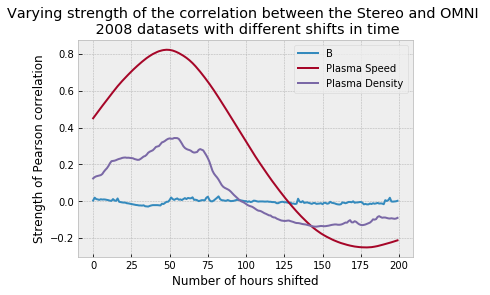

In [ ]:
#2008 correlation plot
plt.figure()
plt.style.use("bmh")
plt.plot(list(b08.keys()),list(b08.values()), label = "B")
plt.plot(list(speed08.keys()),list(speed08.values()), label = "Plasma Speed")
plt.plot(list(density08.keys()),list(density08.values()), label = "Plasma Density")
plt.legend()
plt.xlabel("Number of hours shifted")
plt.ylabel("Strength of Pearson correlation")
plt.title("Varying strength of the correlation between the Stereo and OMNI \n 2008 datasets with different shifts in time")
plt.show

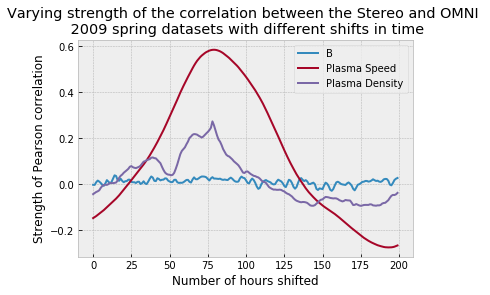

In [ ]:
#plot the correlation for 2009 summer
plt.figure()
plt.style.use("bmh")
plt.plot(list(b09s.keys()),list(b09s.values()), label = "B")
plt.plot(list(speed09s.keys()),list(speed09s.values()), label = "Plasma Speed")
plt.plot(list(density09s.keys()),list(density09s.values()), label = "Plasma Density")
plt.legend()
plt.xlabel("Number of hours shifted")
plt.ylabel("Strength of Pearson correlation")
plt.title("Varying strength of the correlation between the Stereo and OMNI \n 2009 spring datasets with different shifts in time")
plt.show()

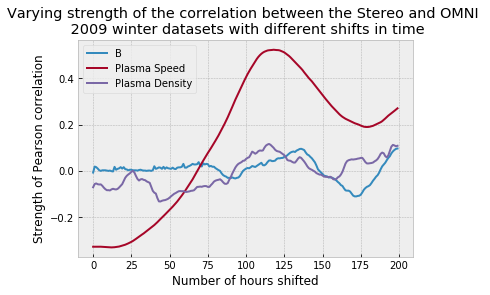

In [ ]:
#plot the correlation for 2009 winter
plt.figure()
plt.style.use("bmh")
plt.plot(list(b09w.keys()),list(b09w.values()), label = "B")
plt.plot(list(speed09w.keys()),list(speed09w.values()), label = "Plasma Speed")
plt.plot(list(density09w.keys()),list(density09w.values()), label = "Plasma Density")
plt.legend()
plt.xlabel("Number of hours shifted")
plt.ylabel("Strength of Pearson correlation")
plt.title("Varying strength of the correlation between the Stereo and OMNI \n 2009 winter datasets with different shifts in time")
plt.show()

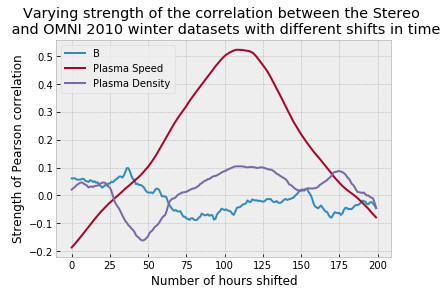

In [ ]:
#plot the correlation for 2010 winter
plt.figure()
plt.style.use("bmh")
plt.plot(list(b10.keys()),list(b10.values()), label = "B")
plt.plot(list(speed10.keys()),list(speed10.values()), label = "Plasma Speed")
plt.plot(list(density10.keys()),list(density10.values()), label = "Plasma Density")
plt.legend()
plt.title("Varying strength of the correlation between the Stereo \n and OMNI 2010 winter datasets with different shifts in time")
plt.xlabel("Number of hours shifted")
plt.ylabel("Strength of Pearson correlation")
plt.show()

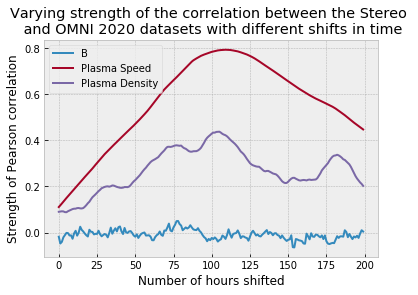

In [ ]:
#plot the correlation for 2020
plt.figure()
plt.style.use("bmh")
plt.plot(list(b20.keys()),list(b20.values()), label = "B")
plt.plot(list(speed20.keys()),list(speed20.values()), label = "Plasma Speed")
plt.plot(list(density20.keys()),list(density20.values()), label = "Plasma Density")
plt.legend()
plt.xlabel("Number of hours shifted")
plt.ylabel("Strength of Pearson correlation")
plt.title("Varying strength of the correlation between the Stereo \n and OMNI 2020 datasets with different shifts in time")
plt.show()

In [ ]:


max08 = max(speed08, key = speed08.get)
maxp08 = max(speed08.values())
print("The shift that maximises the correlation for the 2008 dataset is ", max08, "hours with a maximum correlation of ", maxp08)

#shift the stereo datasets back to maximise the correlation


max09s = max(speed09s, key = speed09s.get)
maxp09s = max(speed09s.values())
print("The shift that maximises the correlation for the 2009 spring dataset is ", max09s, "hours with a maximum correlation of ", maxp09s)

#shift the stereo datasets back to maximise the correlation


max09w = max(speed09w, key = speed09w.get)
maxp09w = max(speed09w.values())
print("The shift that maximises the correlation for the 2009 winter dataset is ", max09w, "hours with a maximum correlation of ", maxp09w)


max10 = max(speed10, key = speed10.get)
maxp10 = max(speed10.values())
print("The shift that maximises the correlation for the 2010 dataset is ", max10, "hours with a maximum correlation of ", maxp10)

#find the alignment that maximises the correlation coefficients
max20 = max(speed20, key = speed20.get)
maxp20 = max(speed20.values())
print("The shift that maximises the correlation for the 2020 dataset is " , max20, "hours with a maximum correlation of ", maxp20 )

#shift the stereo datasets back to maximise the correlation



The shift that maximises the correlation for the 2008 dataset is  48 hours with a maximum correlation of  0.8228098922683212
The shift that maximises the correlation for the 2009 spring dataset is  79 hours with a maximum correlation of  0.5853912318602664
The shift that maximises the correlation for the 2009 winter dataset is  118 hours with a maximum correlation of  0.5229513755731112
The shift that maximises the correlation for the 2010 dataset is  109 hours with a maximum correlation of  0.52335196392878
The shift that maximises the correlation for the 2020 dataset is  109 hours with a maximum correlation of  0.7933492414710369


In [ ]:
#shift the stereo datasets to maximise the correlation
#instead of using the calculated correlations use the theoretical ones
sta20 = sta20.shift(108)
stb08 = stb08.shift(66) #72
stb09s = stb09s.shift(84)
stb09w = stb09w.shift(108)
stb10 = stb10.shift(121)

In [ ]:

#plot the 2020 data  
#plt.figure()
#plt.plot(sta20["Time"], sta20["PlasmaSpeed"])
#plt.scatter(omni20["Time"], omni20["PlasmaSpeed"])
#plt.title("Plasma Speed as measured at L1 and L5 over late 2020")
#plt.show()
#


<Figure size 432x288 with 0 Axes>

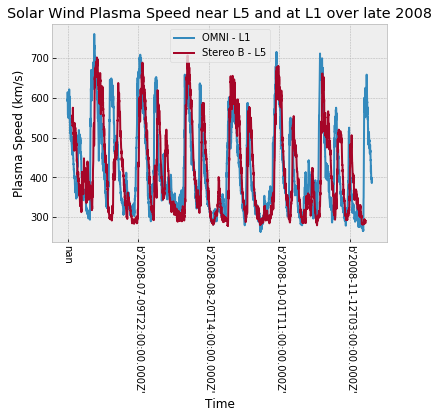

In [ ]:

#plot the 2008 data, the stereo, omni, goes and DST data
plt.figure()
plt.style.use("bmh")
ax = omni08.plot(x = "Time", y = "plasmaSpeed", label = "OMNI - L1 ")
stb08.plot( x = "Time", y = "plasmaSpeed", ax = ax, label = "Stereo B - L5")
#compgoes08.plot(x = "Time", y = "E2M", ax = ax, label = "GOES Adjusted Electron Flux - Earth - Shifted forward by 40 hours")
plt.title("Solar Wind Plasma Speed near L5 and at L1 over late 2008")
plt.ylabel("Plasma Speed (km/s)")
plt.xticks( rotation= - 90)
plt.show()



<Figure size 432x288 with 0 Axes>

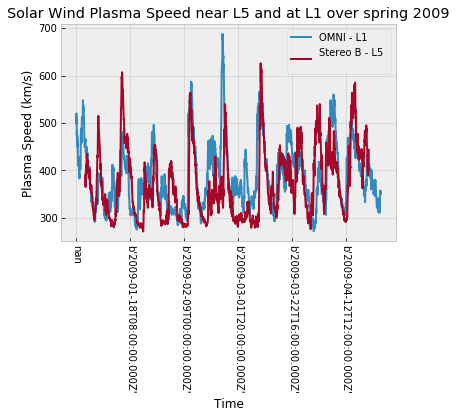

In [ ]:
#plot the 2009 springdata
plt.figure()
plt.style.use("bmh")
ax = omni09s.plot(x = "Time", y = "plasmaSpeed", label = "OMNI - L1 ")
stb09s.plot( x = "Time", y = "plasmaSpeed", ax = ax, label = "Stereo B - L5 \n")
#compgoes08.plot(x = "Time", y = "E2M", ax = ax, label = "GOES Adjusted Electron Flux - Earth - Shifted forward by 40 hours")
plt.title("Solar Wind Plasma Speed near L5 and at L1 over spring 2009")
plt.ylabel("Plasma Speed (km/s)")
plt.xticks( rotation= - 90)
plt.show()

<Figure size 432x288 with 0 Axes>

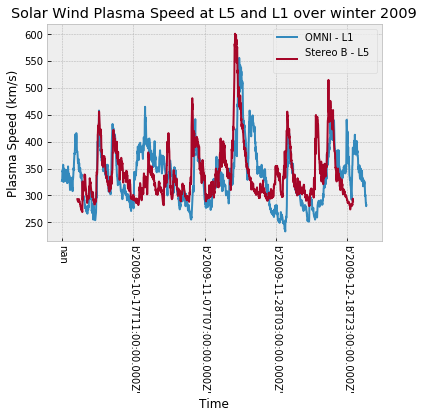

In [ ]:
#plot the winter 2009 data
plt.figure()
plt.style.use("bmh")
ax = omni09w.plot(x = "Time", y = "plasmaSpeed", label = "OMNI - L1 ")
stb09w.plot( x = "Time", y = "plasmaSpeed", ax = ax, label = "Stereo B - L5 \n")
#compgoes08.plot(x = "Time", y = "E2M", ax = ax, label = "GOES Adjusted Electron Flux - Earth - Shifted forward by 40 hours")
plt.title("Solar Wind Plasma Speed at L5 and L1 over winter 2009")
plt.ylabel("Plasma Speed (km/s)")
plt.xticks( rotation= - 90)
plt.show()

In [ ]:
#hapiplot(goes08np,goes08meta)

<Figure size 432x288 with 0 Axes>

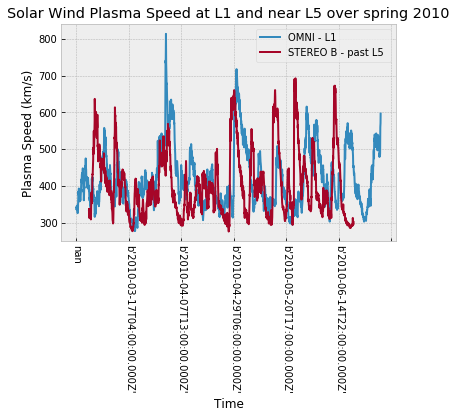

In [ ]:
#plot the 2010 data of stereo and omni


plt.figure()
plt.style.use("bmh")
ax = omni10.plot(x = "Time", y = "plasmaSpeed", label = "OMNI - L1")
stb10.plot( x= "Time", y = "plasmaSpeed", label = "STEREO B - past L5 ", ax = ax)

plt.title("Solar Wind Plasma Speed at L1 and near L5 over spring 2010")
plt.ylabel("Plasma Speed (km/s)")
plt.xticks( rotation= - 90)
plt.show()

<Figure size 432x288 with 0 Axes>

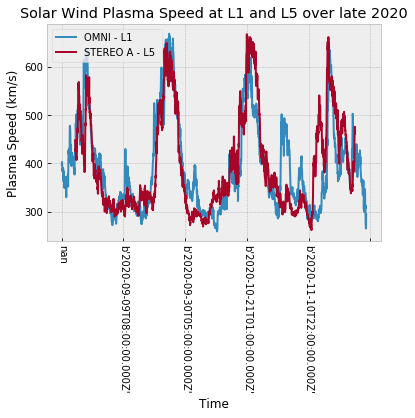

In [ ]:
#plot the 2020 data of stereo and omni


plt.figure()
plt.style.use("bmh")
ax = omni20.plot(x = "Time", y = "plasmaSpeed", label = "OMNI - L1")
sta20.plot( x= "Time", y = "plasmaSpeed", label = "STEREO A - L5 ", ax = ax)

plt.title("Solar Wind Plasma Speed at L1 and L5 over late 2020")
plt.ylabel("Plasma Speed (km/s)")
plt.xticks( rotation= - 90)
plt.show()

In [ ]:
#find the correlations of the 2008 data satellite data with the goes data
#o08 = compgoes08.corrwith(omni08["PlasmaSpeed"], axis = 0, drop = True, method = "pearson")
#s08 = compgoes08.corrwith(stb08["PlasmaSpeed"], axis = 0, drop = True, method = "pearson")
#print("The omni and goes data correlation is: ", o08, "The stereo and goes data correlation is: ", s08)

The time taken for the effects of the plasma flux from the solar wind to be observed by the GOES sensors is -40 hours, with a correlation between the data of 0.3724794077629587


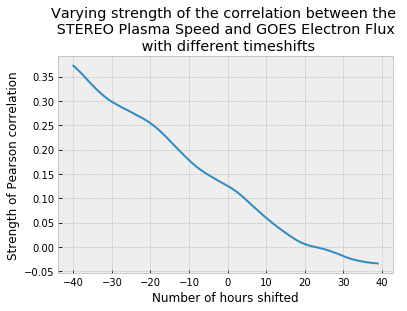

In [ ]:
#start a for loop to iterate through each correlation at different time shifts for the goes data from the others
compgoes08 = compgoes08.shift(-40)
compgoes08["plasmaSpeed"]= compgoes08["E2"]
g08 = {}

for i in range(-40,40,1):
    stb08 = stb08.shift(1)
    s08 = compgoes08.corrwith(stb08["plasmaSpeed"], axis = 0, drop = True, method = "pearson")
    g08[(i)]= s08[2]
    

stb08 = stb08.shift(-40)
plt.figure()
plt.style.use("bmh")
plt.plot(list(g08.keys()),list(g08.values()))
plt.xlabel("Number of hours shifted")
plt.ylabel("Strength of Pearson correlation")
plt.title("Varying strength of the correlation between the \n STEREO Plasma Speed and GOES Electron Flux \n with different timeshifts")
plt.show

gmax = max(g08, key = g08.get)
print ("The time taken for the effects of the plasma flux from the solar wind to be observed by the GOES sensors is" , gmax , "hours, with a correlation between the data of", g08[gmax])

#compgoes08 = compgoes08.shift(-gmax)
#not getting the right result for maximum correlation, should have been about 12 hours instead

<Figure size 432x288 with 0 Axes>

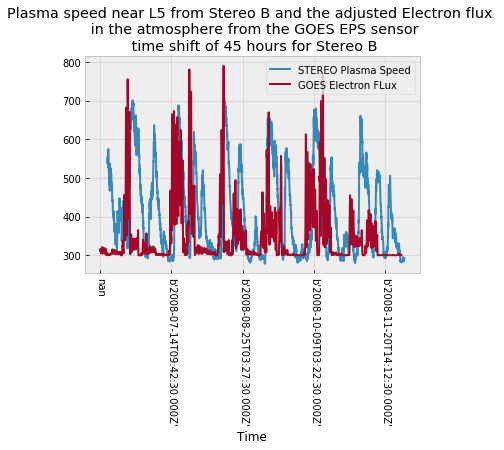

In [ ]:
#plot the goes data between stereo and goes, 2008 
compgoes08 = compgoes08.shift(1)
plt.figure()
plt.style.use("bmh")
ax = stb08.plot( x = "Time", y = "plasmaSpeed", label = "STEREO Plasma Speed")
compgoes08.plot(x = "Time", y = "E2M",label = "GOES Electron FLux", ax = ax)
plt.title("Plasma speed near L5 from Stereo B and the adjusted Electron flux \n in the atmosphere from the GOES EPS sensor\n time shift of 45 hours for Stereo B")
plt.xticks( rotation= - 90)
plt.show()

<Figure size 432x288 with 0 Axes>

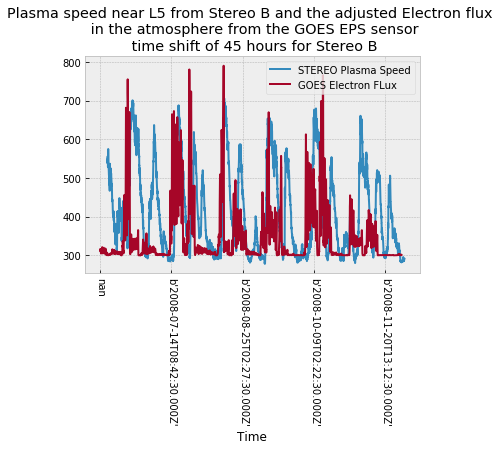

In [ ]:
#plot the goes data between stereo and goes, 2008 
compgoes08 = compgoes08.shift(1)
plt.figure()
plt.style.use("bmh")
ax = stb08.plot( x = "Time", y = "plasmaSpeed", label = "STEREO Plasma Speed")
compgoes08.plot(x = "Time", y = "E2M",label = "GOES Electron FLux", ax = ax)
plt.title("Plasma speed near L5 from Stereo B and the adjusted Electron flux \n in the atmosphere from the GOES EPS sensor\n time shift of 45 hours for Stereo B")
plt.xticks( rotation= - 90)
plt.show()

<Figure size 432x288 with 0 Axes>

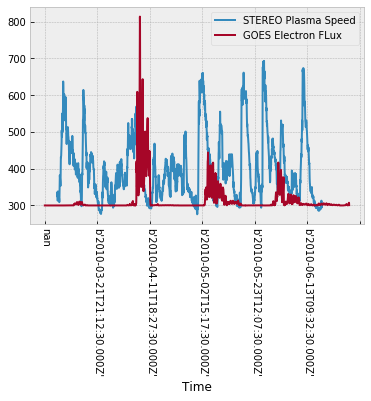

In [ ]:
#plot the goes data between stereo and goes, 2010
compgoes10 = compgoes10.shift(1)
plt.figure()
plt.style.use("bmh")
ax = stb10.plot( x = "Time", y = "plasmaSpeed", label = "STEREO Plasma Speed")
compgoes10.plot(x = "Time", y = "E2M",label = "GOES Electron FLux", ax = ax)
#plt.title("2010 spring - Plasma speed near L5 from Stereo B and the adjusted Electron flux \n in the atmosphere from the GOES EPS sensor\n time shift of 45 hours for Stereo B")
plt.xticks( rotation= - 90)
plt.show()

<Figure size 432x288 with 0 Axes>

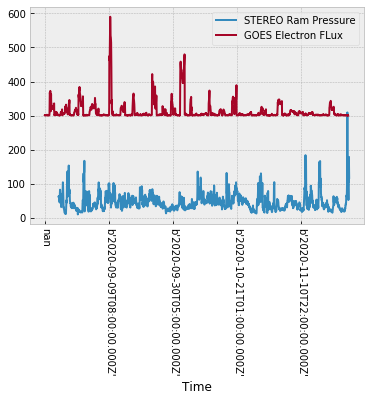

In [ ]:
#plot the goes 2020 data
plt.figure()
plt.style.use("bmh")
ax = sta20.plot( x = "Time", y = "P", label = "STEREO Ram Pressure")
compgoes20.plot( y = "E2M",label = "GOES Electron FLux", ax = ax)
#plt.title("Plasma speed at L5 from Stereo A and the adjusted Electron flux \n in the atmosphere from the GOES EPS sensor\n time shift of 120 hours for Stereo B")
plt.xticks( rotation= - 90)
#plt.ylabel("Plasma speed (km/s) and adjusted Electron Flux")
plt.show()

<Figure size 432x288 with 0 Axes>

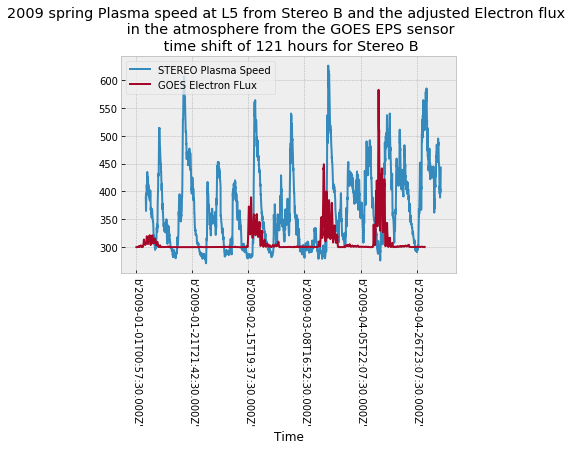

In [ ]:
plt.figure()
plt.style.use("bmh")
ax = stb09s.plot( x = "Time", y = "plasmaSpeed", label = "STEREO Plasma Speed")
compgoes09s.plot(x = "Time", y = "E2M",label = "GOES Electron FLux", ax = ax)
plt.title("2009 spring Plasma speed at L5 from Stereo B and the adjusted Electron flux \n in the atmosphere from the GOES EPS sensor\n time shift of 121 hours for Stereo B")
plt.xticks( rotation= - 90)
plt.show()

<Figure size 432x288 with 0 Axes>

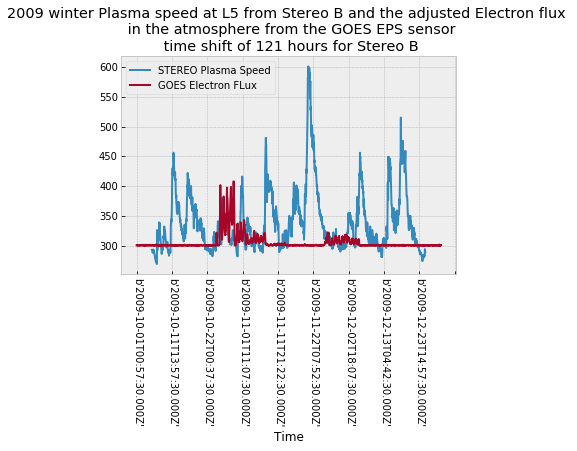

In [ ]:
plt.figure()
plt.style.use("bmh")
ax = stb09w.plot( x = "Time", y = "plasmaSpeed", label = "STEREO Plasma Speed")
compgoes09w.plot(x = "Time", y = "E2M",label = "GOES Electron FLux", ax = ax)
plt.title("2009 winter Plasma speed at L5 from Stereo B and the adjusted Electron flux \n in the atmosphere from the GOES EPS sensor\n time shift of 121 hours for Stereo B")
plt.xticks( rotation= - 90)
plt.show()

Start up the truthtable for the thresholds of 1000 and 10000 electrons per square cm
Try forecast levels from 2020 paper!
consider cases where it does not agree between l5 and goes, consider magnetic flux maybe?

In [ ]:
#import the enlils model data 
#from scipy.io import netcdf_file
#fp='/Users/macintosh/Desktop/work/UCL/files/Investigations into October 2020 CRI/predictions/archive-item-465056/models/space_weather/enlil/2020/11/swpc_wsaenlil_bkg_20201104_0000/wsa_enlil.latest.suball.nc'
#nc = netcdf_file(fp)
#print (nc[0])
#plt.figure()
#plt.imshow(nc)
#plt.show()

In [ ]:
#print(omni08["BN"])

#set up the prediction algorithm

#measure the previous 6 days of wind - if --% is above x values, then check if the electron flux is above certain values.

In [ ]:
#make new dataframe with all the datapoints for each year, timeshifted

d2008 = pd.DataFrame()
d2008["Time"] = compgoes08["Time"]
d2008["StereoBPlasmaSpeed"] = stb08["plasmaSpeed"]
d2008["OMNIPlasmaSpeed"] = omni08["plasmaSpeed"]
d2008["OMNIMagneticField"]= omni08["B"]
d2008["GOESElectronFlux"] = compgoes08["E2"]
d2008["StereoBPlasmaDensity"] = stb08["plasmaDensity"]
d2008["OMNIP"] = omni08["P"]
#d2008["DST"]= dst08["DST"]


#result = pd.concat([stb08, omni08, compgoes08, dst08], axis = 1 ,join='inner', sort = True)
#display(result)

#make new columns to indicate if the values are above the thresholds
d2008["GOES>1000"] = d2008['GOESElectronFlux'].gt(1000)
d2008["GOES>10000"] = d2008['GOESElectronFlux'].gt(10000)
d2008["STBPlasmaSpeed>400"] = d2008["StereoBPlasmaSpeed"].gt(400)
d2008["OMNIPlasmaSpeed>400"] = d2008["OMNIPlasmaSpeed"].gt(400)
d2008["OMNIBNorth"] = d2008["OMNIMagneticField"].gt(0)





In [ ]:
#attempt for 2020 dataset - this has not worked well so far
d2020 = pd.DataFrame()
d2020["Time"]= compgoes20["Time"]
d2020["StereoAP"] = sta20["P"]
d2020["StereoAplasmaSpeed"] = sta20["plasmaSpeed"]
d2020["GOESElectronFlux"] = compgoes20["E2"]

d2020["GOES>1000"] = d2020["GOESElectronFlux"].gt(1000)
d2020["GOES>10000"] = d2020["GOESElectronFlux"].gt(10000)
d2020["STAPlasmaSpeed>400"] = d2020["StereoAplasmaSpeed"].gt(385)


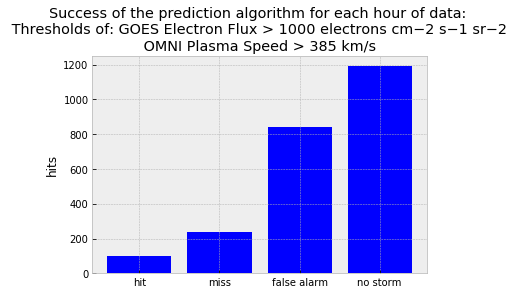

{'hit': 102, 'miss': 237, 'false alarm': 840, 'no storm': 1191}


In [ ]:
#make a dictionary 
x1 = {"hit":0 ,"miss":0, "false alarm":0, "no storm":0}

#now loop over each value in the dataframe for each of the axes 
for e, f, g in zip(d2020["GOES>1000"], d2020["GOES>10000"],d2020["STAPlasmaSpeed>400"]):
    if e == True:
        if g == True:
            x1["hit"] = x1["hit"] + 1
        else:
            x1["miss"] = x1["miss"]+1   
    else:
        if g == True:
            x1["false alarm"] = x1["false alarm"]+1
            
        else:
            x1["no storm"] = x1["no storm"]+1
    
#make a bar chart to illustrate the algorithm method
plt.figure()
plt.bar(list(x1.keys()), x1.values(), color='b')
plt.ylabel("hits")
plt.title("Success of the prediction algorithm for each hour of data: \n Thresholds of: GOES Electron Flux > 1000 electrons cm−2 s−1 sr−2 \n OMNI Plasma Speed > 385 km/s ")
plt.show()

print(x1)

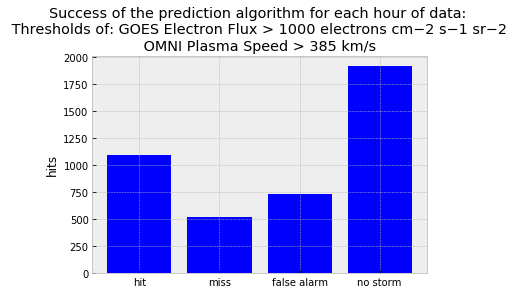

{'hit': 1098, 'miss': 519, 'false alarm': 733, 'no storm': 1916}


In [ ]:
#run the basic prediction for omni, 2008

#make a dictionary
x1 = {"hit":0 ,"miss":0, "false alarm":0, "no storm":0}

#now loop over each value in the dataframe for each of the axes 
for e, f, g in zip(d2008["GOES>1000"], d2008["GOES>10000"],d2008["OMNIPlasmaSpeed>400"]):
    if e == True:
        if g == True:
            x1["hit"] = x1["hit"] + 1
        else:
            x1["miss"] = x1["miss"]+1   
    else:
        if g == True:
            x1["false alarm"] = x1["false alarm"]+1
            
        else:
            x1["no storm"] = x1["no storm"]+1
    
#make a bar chart to illustrate the algorithm method
plt.figure()
plt.bar(list(x1.keys()), x1.values(), color='b')
plt.ylabel("hits")
plt.title("Success of the prediction algorithm for each hour of data: \n Thresholds of: GOES Electron Flux > 1000 electrons cm−2 s−1 sr−2 \n OMNI Plasma Speed > 385 km/s ")
plt.show()

print(x1)

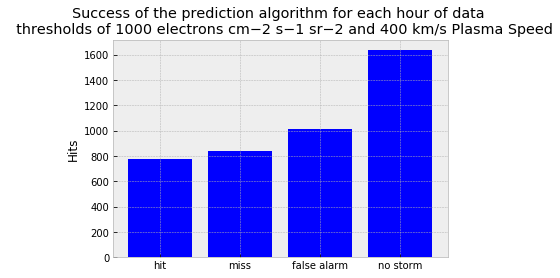

{'hit': 775, 'miss': 842, 'false alarm': 1013, 'no storm': 1636}


In [ ]:
#run the basic prediction for stereo

#make a dictionary
x1 = {"hit":0 ,"miss":0, "false alarm":0, "no storm":0}

#now loop over each value in the dataframe for each of the axes 
for e, f, g in zip(d2008["GOES>1000"], d2008["GOES>10000"],d2008["STBPlasmaSpeed>400"]):
    if e == True:
        if g == True:
            x1["hit"] = x1["hit"] + 1
        else:
            x1["miss"] = x1["miss"]+1   
    else:
        if g == True:
            x1["false alarm"] = x1["false alarm"]+1
            
        else:
            x1["no storm"] = x1["no storm"]+1
    
#make a bar chart to illustrate the algorithm method
plt.figure()
plt.bar(list(x1.keys()), x1.values(), color='b')
plt.ylabel("Hits")
plt.title("Success of the prediction algorithm for each hour of data \n  thresholds of 1000 electrons cm−2 s−1 sr−2 and 400 km/s Plasma Speed")
plt.show()

print(x1)

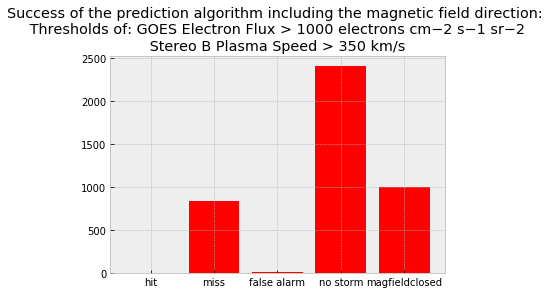

{'hit': 3, 'miss': 842, 'false alarm': 12, 'no storm': 2408, 'magfieldclosed': 1001}


In [ ]:
#run the prediction for stereo with the omni magnetic field filter in as well


#make a dictionary
xm = {"hit":0 ,"miss":0, "false alarm":0, "no storm":0, "magfieldclosed":0}

#now loop over each value in the dataframe for each of the axes 
for e, f, g, h in zip(d2008["GOES>1000"], d2008["GOES>10000"],d2008["STBPlasmaSpeed>400"],d2008["OMNIBNorth"]):
    #if the electron flux is over threshold
    if e == True:
        #if the 
        if g == True:
            if h == False:
                xm["hit"] = xm["hit"] + 1
            else:
                xm["no storm"] = xm["no storm"] + 1
        else:
            xm["miss"] = xm["miss"]+1   
    else:
        if g == True:
            xm["false alarm"] = xm["false alarm"]+1
            #also add a line here to check if the magnetic field at OMNI is south facing
            if h == True:
                xm["false alarm"] = xm["false alarm"]-1
                xm["magfieldclosed"] = xm["magfieldclosed"]+1
        else:
            xm["no storm"] = xm["no storm"]+1
    
#make a bar chart to illustrate the algorithm method
plt.figure()
plt.bar(list(xm.keys()), xm.values(), color='r')
plt.title("Success of the prediction algorithm including the magnetic field direction: \n Thresholds of: GOES Electron Flux > 1000 electrons cm−2 s−1 sr−2 \n Stereo B Plasma Speed > 350 km/s ")
plt.show()

print(xm)

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


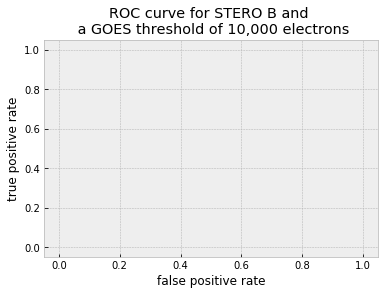

ValueError: max() arg is an empty sequence

In [ ]:
#now we try this whole thing but vary the initial thresholds to get a roc curve

roc = pd.DataFrame(columns = ["tpr","fpr","p"])
for i in range (0,1000,1):
    #make new columns to indicate if the values are above the thresholds
    d2008["STBPlasmaSpeed>x"] = d2008["StereoBPlasmaSpeed"].gt(i)
    #d2008["StereoBPlasmaDensity>x"]= d2008["StereoBPlasmaDensity"].gt(i)
    #make a dictionary
    x = {"hit":0 ,"miss":0, "false alarm":0, "no storm":0, "magfieldclosed":0}

    #now loop over each value in the dataframe for each of the axes - using omni for the moment as stereo does not work
    for f,e, g, k in zip(d2008["GOES>1000"], d2008["GOES>10000"],d2008["STBPlasmaSpeed>x"],d2008["OMNIBNorth"]):
        if e == True:
            if g == True:
                x["hit"] = x["hit"] + 1
            else:
                x["miss"] = x["miss"]+1  
                
        else:
            if g == True:
                x["false alarm"] = x["false alarm"]+1
                #also add a line here to check if the magnetic field at OMNI is south facing
                if k == True:
                    x["false alarm"] = x["false alarm"]-1
                    x["no storm"] = x["no storm"]+1
            else:
                x["no storm"] = x["no storm"]+1
    
    #calculate roc and other statistics            
    tpr = (x["hit"]/(x["hit"]+ x["miss"]))
    fpr = ((x["false alarm"])/ ((x["false alarm"] + x["no storm"])))
    p = tpr - fpr
    roc["tpr"].loc[i] = tpr
    roc["fpr"].loc[i] = fpr
    roc["p"].loc[i] = p
    

#plot roc curve
plt.figure()
plt.plot(roc["fpr"],roc["tpr"])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.xticks(ticks=(0.0,0.2,0.4,0.6,0.8,1.0))
plt.title("ROC curve for STERO B and \n a GOES threshold of 10,000 electrons")
plt.show()

print("The maximum p-score for the two conditions is: ", max(roc["p"]))
